# Imports

In [1]:
import sys
import os
import wandb
parent_dir = os.path.abspath('..')
sys.path.append(parent_dir)

from datasets import load_dataset
import random
from nnsight import LanguageModel 
import torch as t
from torch import nn
# from attribution import patching_effect
from dictionary_learning import AutoEncoder, ActivationBuffer
# from dictionary_learning.dictionary import IdentityDict
# from dictionary_learning.interp import examine_dimension
# from dictionary_learning.utils import hf_dataset_to_generator
from tqdm import tqdm
import gc

DEBUGGING = False

if DEBUGGING:
    tracer_kwargs = dict(scan=True, validate=True)
else:
    tracer_kwargs = dict(scan=False, validate=False)

# model hyperparameters
DEVICE = 'cpu'
model = LanguageModel('EleutherAI/pythia-70m-deduped', device_map=DEVICE, dispatch=True)
activation_dim = 512

/Users/maheepchaudhary/miniforge3/envs/nnsight/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/maheepchaudhary/miniforge3/envs/nnsight/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [2]:
import pickle as pkl

class Probe(nn.Module):
    def __init__(self, activation_dim):
        super().__init__()
        self.net = nn.Linear(activation_dim, 1, bias=True)

    def forward(self, x):
        logits = self.net(x).squeeze(-1)
        return logits

with open("probe_shift.pkl", "rb") as f:
    probe = pkl.load(f)

In [4]:
probe.to(DEVICE)
probe.net(t.zeros((512)).to(DEVICE))

tensor([-0.0300], grad_fn=<ViewBackward0>)

In [5]:
# loading dictionaries

# dictionary hyperparameters
dict_id = 10
expansion_factor = 64
dictionary_size = expansion_factor * activation_dim
layer = 4

submodules = []
dictionaries = {}

submodules.append(model.gpt_neox.embed_in)
dictionaries[model.gpt_neox.embed_in] = AutoEncoder.from_pretrained(
    f'/Users/maheepchaudhary/pytorch/Projects/concept_eraser_research/DAS_MAT/baulab.us/u/smarks/autoencoders/pythia-70m-deduped/embed/{dict_id}_{dictionary_size}/ae.pt',
    device=DEVICE
)
for i in range(layer + 1):
    submodules.append(model.gpt_neox.layers[i].attention)
    dictionaries[model.gpt_neox.layers[i].attention] = AutoEncoder.from_pretrained(
        f'/Users/maheepchaudhary/pytorch/Projects/concept_eraser_research/DAS_MAT/baulab.us/u/smarks/autoencoders/pythia-70m-deduped/attn_out_layer{i}/{dict_id}_{dictionary_size}/ae.pt',
        device=DEVICE
    )

    submodules.append(model.gpt_neox.layers[i].mlp)
    dictionaries[model.gpt_neox.layers[i].mlp] = AutoEncoder.from_pretrained(
        f'/Users/maheepchaudhary/pytorch/Projects/concept_eraser_research/DAS_MAT/baulab.us/u/smarks/autoencoders/pythia-70m-deduped/mlp_out_layer{i}/{dict_id}_{dictionary_size}/ae.pt',
        device=DEVICE
    )

    submodules.append(model.gpt_neox.layers[i])
    dictionaries[model.gpt_neox.layers[i]] = AutoEncoder.from_pretrained(
        f'/Users/maheepchaudhary/pytorch/Projects/concept_eraser_research/DAS_MAT/baulab.us/u/smarks/autoencoders/pythia-70m-deduped/resid_out_layer{i}/{dict_id}_{dictionary_size}/ae.pt',
        device=DEVICE
    )

# metric fn is used to 
def metric_fn(model, labels=None):
    attn_mask = model.input[1]['attention_mask']
    acts = model.gpt_neox.layers[layer].output[0]
    acts = acts * attn_mask[:, :, None]
    acts = acts.sum(1) / attn_mask.sum(1)[:, None]
    
    return t.where(
        labels == 0,
        probe(acts),
        - probe(acts)
    )

In [ ]:
print(model)

GPTNeoXForCausalLM(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(50304, 512)
    (emb_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-5): 6 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (post_attention_dropout): Dropout(p=0.0, inplace=False)
        (post_mlp_dropout): Dropout(p=0.0, inplace=False)
        (attention): GPTNeoXAttention(
          (rotary_emb): GPTNeoXRotaryEmbedding()
          (query_key_value): Linear(in_features=512, out_features=1536, bias=True)
          (dense): Linear(in_features=512, out_features=512, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=512, out_features=2048, bias=True)
          (dense_4h_to_h): Linear(in_features=2048, out_features=512, bias=True)
          (a

# Data Processing

In [6]:
# dataset hyperparameters
dataset = load_dataset("LabHC/bias_in_bios")
profession_dict = {'professor' : 21, 'nurse' : 13}
male_prof = 'professor'
female_prof = 'nurse'

# data preparation hyperparameters
# batch_size = 512

SEED = 42

# To fit on 24GB VRAM GPU, I set the next 2 default batch_sizes to 64
def get_data(train=True, ambiguous=True, batch_size=1, seed=SEED):
    if train:
        data = dataset['train']
    else:
        data = dataset['test']
    if ambiguous:
        neg = [x['hard_text'] for x in data if x['profession'] == profession_dict[male_prof] and x['gender'] == 0]
        pos = [x['hard_text'] for x in data if x['profession'] == profession_dict[female_prof] and x['gender'] == 1]
        n = min([len(neg), len(pos)])
        neg, pos = neg[:n], pos[:n]
        data = neg + pos
        labels = [0]*n + [1]*n
        idxs = list(range(2*n))
        random.Random(seed).shuffle(idxs)
        data, labels = [data[i] for i in idxs], [labels[i] for i in idxs]
        true_labels = spurious_labels = labels
    else:
        neg_neg = [x['hard_text'] for x in data if x['profession'] == profession_dict[male_prof] and x['gender'] == 0]
        neg_pos = [x['hard_text'] for x in data if x['profession'] == profession_dict[male_prof] and x['gender'] == 1]
        pos_neg = [x['hard_text'] for x in data if x['profession'] == profession_dict[female_prof] and x['gender'] == 0]
        pos_pos = [x['hard_text'] for x in data if x['profession'] == profession_dict[female_prof] and x['gender'] == 1]
        n = min([len(neg_neg), len(neg_pos), len(pos_neg), len(pos_pos)])
        neg_neg, neg_pos, pos_neg, pos_pos = neg_neg[:n], neg_pos[:n], pos_neg[:n], pos_pos[:n]
        data = neg_neg + neg_pos + pos_neg + pos_pos
        true_labels     = [0]*n + [0]*n + [1]*n + [1]*n
        spurious_labels = [0]*n + [1]*n + [0]*n + [1]*n
        idxs = list(range(4*n))
        random.Random(seed).shuffle(idxs)
        data, true_labels, spurious_labels = [data[i] for i in idxs], [true_labels[i] for i in idxs], [spurious_labels[i] for i in idxs]

    batches = [
        (data[i:i+batch_size], t.tensor(true_labels[i:i+batch_size], device=DEVICE), t.tensor(spurious_labels[i:i+batch_size], device=DEVICE)) for i in range(0, len(data), batch_size)
    ]

    return batches

def get_subgroups(train=True, ambiguous=True, batch_size=1, seed=SEED):
    if train:
        data = dataset['train']
    else:
        data = dataset['test']
    if ambiguous:
        neg = [x['hard_text'] for x in data if x['profession'] == profession_dict[male_prof] and x['gender'] == 0]
        pos = [x['hard_text'] for x in data if x['profession'] == profession_dict[female_prof] and x['gender'] == 1]
        neg_labels, pos_labels = (0, 0), (1, 1)
        subgroups = [(neg, neg_labels), (pos, pos_labels)]
    else:
        neg_neg = [x['hard_text'] for x in data if x['profession'] == profession_dict[male_prof] and x['gender'] == 0]
        neg_pos = [x['hard_text'] for x in data if x['profession'] == profession_dict[male_prof] and x['gender'] == 1]
        pos_neg = [x['hard_text'] for x in data if x['profession'] == profession_dict[female_prof] and x['gender'] == 0]
        pos_pos = [x['hard_text'] for x in data if x['profession'] == profession_dict[female_prof] and x['gender'] == 1]
        neg_neg_labels, neg_pos_labels, pos_neg_labels, pos_pos_labels = (0, 0), (0, 1), (1, 0), (1, 1)
        subgroups = [(neg_neg, neg_neg_labels), (neg_pos, neg_pos_labels), (pos_neg, pos_neg_labels), (pos_pos, pos_pos_labels)]
    
    out = {}
    for data, label_profile in subgroups:
        out[label_profile] = []
        for i in range(0, len(data), batch_size):
            text = data[i:i+batch_size]
            out[label_profile].append(
                (
                    text,
                    t.tensor([label_profile[0]]*len(text), device=DEVICE),
                    t.tensor([label_profile[1]]*len(text), device=DEVICE)
                )
            )
    return out

# Training

## SCRAP

In [7]:
# from pprint import pprint
# from tqdm import tqdm
# from torch import nn

# text = """The quick brown fox jumps over the lazy dog"""


# '''
# We make a dummy model to see if gradient descent works on the model.
# We will optimize the model to output the zero vector as activation in the end. 

# After that we will analyse the values of each l1, l2, l3, l4 
# to see if the model has learned the values to manipulate the activations of the model.
# '''
    

# class my_model(nn.Module):
#     def __init__(self):
#         super(my_model, self).__init__()
        
#         # We have intergrated the sigmoid_mask from pyvene (https://github.com/stanfordnlp/pyvene/blob/main/pyvene/models/interventions.py) 
        
#         embed_dim = (1,1,32768)
#         self.temperature = t.nn.Parameter(t.tensor(0.01))
        
#         self.embed_mask = t.nn.Parameter(t.zeros(embed_dim), requires_grad=True)
#         self.l1_mask = t.nn.Parameter(t.zeros(embed_dim), requires_grad=True)
#         self.l2_mask = t.nn.Parameter(t.zeros(embed_dim), requires_grad=True)
#         self.l3_mask = t.nn.Parameter(t.zeros(embed_dim), requires_grad=True)
#         self.l4_mask = t.nn.Parameter(t.zeros(embed_dim), requires_grad=True)
#         self.probe = probe.requires_grad_(False)
        
#         # self.probe = Probe
        
#     def forward(self,text):
        
#         embed_mask_sigmoid = t.sigmoid(self.embed_mask / t.tensor(self.temperature.clone().detach())) 
#         l1_mask_sigmoid = t.sigmoid(self.l1_mask / t.tensor(self.temperature.clone().detach())) 
#         l2_mask_sigmoid = t.sigmoid(self.l2_mask / t.tensor(self.temperature.clone().detach()))
#         l3_mask_sigmoid = t.sigmoid(self.l3_mask / t.tensor(self.temperature.clone().detach()))
#         l4_mask_sigmoid = t.sigmoid(self.l4_mask / t.tensor(self.temperature.clone().detach()))
        
#         acts = self.get_acts(text, 0, 'None', 1)
#         print(acts.shape)
#         acts = embed_mask_sigmoid * acts
#         acts = self.get_acts(text, 1, acts, 2)
#         acts = l1_mask_sigmoid * acts
#         acts = self.get_acts(text, 2, acts, 3)
#         acts = l2_mask_sigmoid * acts
#         acts = self.get_acts(text, 3, acts, 4)
#         acts = l3_mask_sigmoid * acts
#         acts = self.get_acts(text, 4, acts, 5)
#         acts = l4_mask_sigmoid * acts
#         acts = self.get_acts(text, 5, acts, 6)
#         acts = acts.sum(1)
#         acts = self.probe.net(acts).squeeze(-1)
    
#         return acts

#     '''
#     The get_acts function is used to get the activations of the model at a particular layer 
#     after getting intervened at a particular layer.
#     '''
    
#     def get_acts(self, text, intervention_layer, acts, get_act_layer):
#         with model.trace(text):
#             i = 0
#             for module in submodules:
                
#                 if type(module.output.shape) != tuple:
                    
#                     if acts == 'None':
#                         new_acts = module.output.save()
#                         dictionary = dictionaries[module]
#                         new_acts = dictionary.encode(new_acts).save()
                    
#                     elif get_act_layer == 6:
#                         new_acts = dictionaries[module].decode(acts)
                    
#                     else:    
#                         if i == intervention_layer:
#                             dictionary = dictionaries[module]
#                             acts = dictionary.decode(acts)
#                             module.out = acts
#                         elif i == get_act_layer:
#                             new_acts = module.output
#                             new_acts = dictionaries[module].encode(new_acts).save()
                        
                    
#                     i+=1
#         return new_acts

In [8]:
# from pprint import pprint
# from tqdm import tqdm
# from torch import nn

# text = """The quick brown fox jumps over the lazy dog"""


# '''
# We make a dummy model to see if gradient descent works on the model.
# We will optimize the model to output the zero vector as activation in the end. 

# After that we will analyse the values of each l1, l2, l3, l4 
# to see if the model has learned the values to manipulate the activations of the model.

# This model inserts mask at each layer of the model to see if the model can learn to manipulate the activations of the model.
# '''
    

# class my_model(nn.Module):
#     def __init__(self):
#         super(my_model, self).__init__()
        
#         # We have intergrated the sigmoid_mask from pyvene (https://github.com/stanfordnlp/pyvene/blob/main/pyvene/models/interventions.py) 
        
#         embed_dim = (1,1,32768)
#         self.temperature = t.nn.Parameter(t.tensor(0.01))
        
#         self.submodules = []
#         self.dictionaries = {}

#         self.submodules.append(model.gpt_neox.embed_in)
#         self.dictionaries[model.gpt_neox.embed_in] = AutoEncoder.from_pretrained(
#             f'/Users/maheepchaudhary/pytorch/Projects/concept_eraser_research/DAS_MAT/baulab.us/u/smarks/autoencoders/pythia-70m-deduped/embed/{dict_id}_{dictionary_size}/ae.pt',
#             device=DEVICE
#         )
#         for i in range(layer + 1):
#             self.submodules.append(model.gpt_neox.layers[i].attention)
#             self.dictionaries[model.gpt_neox.layers[i].attention] = AutoEncoder.from_pretrained(
#                 f'/Users/maheepchaudhary/pytorch/Projects/concept_eraser_research/DAS_MAT/baulab.us/u/smarks/autoencoders/pythia-70m-deduped/attn_out_layer{i}/{dict_id}_{dictionary_size}/ae.pt',
#                 device=DEVICE
#             )

#             self.submodules.append(model.gpt_neox.layers[i].mlp)
#             self.dictionaries[model.gpt_neox.layers[i].mlp] = AutoEncoder.from_pretrained(
#                 f'/Users/maheepchaudhary/pytorch/Projects/concept_eraser_research/DAS_MAT/baulab.us/u/smarks/autoencoders/pythia-70m-deduped/mlp_out_layer{i}/{dict_id}_{dictionary_size}/ae.pt',
#                 device=DEVICE
#             )

#             self.submodules.append(model.gpt_neox.layers[i])
#             self.dictionaries[model.gpt_neox.layers[i]] = AutoEncoder.from_pretrained(
#                 f'/Users/maheepchaudhary/pytorch/Projects/concept_eraser_research/DAS_MAT/baulab.us/u/smarks/autoencoders/pythia-70m-deduped/resid_out_layer{i}/{dict_id}_{dictionary_size}/ae.pt',
#                 device=DEVICE
#             )
        
#         self.embed_mask = t.nn.Parameter(t.zeros(embed_dim), requires_grad=True)
#         self.l1_mask = t.nn.Parameter(t.zeros(embed_dim), requires_grad=True)
#         self.l2_mask = t.nn.Parameter(t.zeros(embed_dim), requires_grad=True)
#         self.l3_mask = t.nn.Parameter(t.zeros(embed_dim), requires_grad=True)
#         self.l4_mask = t.nn.Parameter(t.zeros(embed_dim), requires_grad=True)
#         self.probe = probe.requires_grad_(False)
        
#         self.module_not_tuple = []
        
        
#         with model.trace(text):
#             for module in submodules:
#                 if type(module.output.shape) != tuple: # if tuple is true then we are reffering to the residual layer.
#                     self.module_not_tuple.append(module)
        
#         # self.probe = Probe
        
        

#     def forward(self,text):
        
#         embed_mask_sigmoid = t.sigmoid(self.embed_mask / t.tensor(self.temperature.clone().detach())) 
#         l1_mask_sigmoid = t.sigmoid(self.l1_mask / t.tensor(self.temperature.clone().detach())) 
#         l2_mask_sigmoid = t.sigmoid(self.l2_mask / t.tensor(self.temperature.clone().detach()))
#         l3_mask_sigmoid = t.sigmoid(self.l3_mask / t.tensor(self.temperature.clone().detach()))
#         l4_mask_sigmoid = t.sigmoid(self.l4_mask / t.tensor(self.temperature.clone().detach()))
        
#         with model.trace(text):
            

#             dictionary = self.dictionaries[self.module_not_tuple[0]]
#             acts = self.module_not_tuple[0].output
#             acts = dictionary.encode(acts).save()
#             acts = embed_mask_sigmoid * acts
#             self.module_not_tuple[0].output = dictionary.decode(acts)
    
            
#             dictionary = self.dictionaries[self.module_not_tuple[1]]
#             acts = self.module_not_tuple[1].output
#             acts = dictionary.encode(acts).save()
#             acts = l1_mask_sigmoid * acts
#             self.module_not_tuple[1].output = dictionary.decode(acts)
            
            
#             dictionary = self.dictionaries[self.module_not_tuple[2]]
#             acts = self.module_not_tuple[2].output
#             acts = dictionary.encode(acts).save()
#             acts = l2_mask_sigmoid * acts
#             self.module_not_tuple[2].output = dictionary.decode(acts)
            
#             dictionary = self.dictionaries[self.module_not_tuple[3]]
#             acts = self.module_not_tuple[3].output
#             acts = dictionary.encode(acts).save()
#             acts = l3_mask_sigmoid * acts
#             self.module_not_tuple[3].output = dictionary.decode(acts)
            
#             dictionary = self.dictionaries[self.module_not_tuple[4]]
#             acts = self.module_not_tuple[4].output
#             acts = dictionary.encode(acts).save()
#             acts = l4_mask_sigmoid * acts
#             acts = dictionary.decode(acts).save()
#             self.module_not_tuple[4].output = acts

            
#         new_acts = acts.sum(1)
#         acts = self.probe.net(new_acts).squeeze(-1)
            
#         return acts


## Intervention on residual layer

In [9]:
# from pprint import pprint
# from tqdm import tqdm
# from torch import nn

# text = """The quick brown fox jumps over the lazy dog"""


# '''
# The model only insert mask at the last residual layer
# '''
    

# class my_model(nn.Module):
#     def __init__(self):
#         super(my_model, self).__init__()
        
#         # We have intergrated the sigmoid_mask from pyvene (https://github.com/stanfordnlp/pyvene/blob/main/pyvene/models/interventions.py) 
        
#         embed_dim = (1,1,32768)
#         self.temperature = t.nn.Parameter(t.tensor(0.01))
        
#         self.submodules = []
#         self.dictionaries = {}


#         self.submodules.append(model.gpt_neox.embed_in)
#         self.dictionaries[model.gpt_neox.embed_in] = AutoEncoder.from_pretrained(
#             f'/Users/maheepchaudhary/pytorch/Projects/concept_eraser_research/DAS_MAT/baulab.us/u/smarks/autoencoders/pythia-70m-deduped/embed/{dict_id}_{dictionary_size}/ae.pt',
#             device=DEVICE
#         )
#         for i in range(layer + 1):
#             self.submodules.append(model.gpt_neox.layers[i].attention)
#             self.dictionaries[model.gpt_neox.layers[i].attention] = AutoEncoder.from_pretrained(
#                 f'/Users/maheepchaudhary/pytorch/Projects/concept_eraser_research/DAS_MAT/baulab.us/u/smarks/autoencoders/pythia-70m-deduped/attn_out_layer{i}/{dict_id}_{dictionary_size}/ae.pt',
#                 device=DEVICE
#             )

#             self.submodules.append(model.gpt_neox.layers[i].mlp)
#             self.dictionaries[model.gpt_neox.layers[i].mlp] = AutoEncoder.from_pretrained(
#                 f'/Users/maheepchaudhary/pytorch/Projects/concept_eraser_research/DAS_MAT/baulab.us/u/smarks/autoencoders/pythia-70m-deduped/mlp_out_layer{i}/{dict_id}_{dictionary_size}/ae.pt',
#                 device=DEVICE
#             )

#             self.submodules.append(model.gpt_neox.layers[i])
#             self.dictionaries[model.gpt_neox.layers[i]] = AutoEncoder.from_pretrained(
#                 f'/Users/maheepchaudhary/pytorch/Projects/concept_eraser_research/DAS_MAT/baulab.us/u/smarks/autoencoders/pythia-70m-deduped/resid_out_layer{i}/{dict_id}_{dictionary_size}/ae.pt',
#                 device=DEVICE
#             )
        
#         self.mask = t.nn.Parameter(t.zeros(embed_dim), requires_grad=True)
#         self.probe = probe.requires_grad_(False)
        
#         self.module_tuple = []
        
        
#         with model.trace(text):
#             for i, module in enumerate(self.submodules):
#                 print(i)
#                 if type(module.output.shape) == tuple: # if tuple is true then we are reffering to the residual layer.
#                     self.module_tuple.append(module)
        
#         for m in self.module_tuple:
#             print(m)
#             print()
            
        
#         # self.probe = Probe
        
        

#     def forward(self,text):
        

#         mask_sigmoid = t.sigmoid(self.mask / t.tensor(self.temperature.clone().detach()))
        
#         with model.trace(text):
            
#             dictionary = self.dictionaries[self.module_tuple[-2]]
#             acts = self.module_tuple[-1].output[0][:].save()
#             acts = dictionary.encode(acts).save()
#             acts = mask_sigmoid * acts
#             self.module_tuple[-1].output[0][:] = dictionary.decode(acts)
#             acts = self.module_tuple[-1].output[0][:].save()
            

#         new_acts = acts.sum(1)
#         acts = self.probe.net(new_acts).squeeze(-1)
            
#         return acts


## Intervention on just last layer

In [7]:
from pprint import pprint
from tqdm import tqdm
from torch import nn

text = """The quick brown fox jumps over the lazy dog"""


'''
We make a dummy model to see if gradient descent works on the model.
We will optimize the model to output the zero vector as activation in the end. 

After that we will analyse the values of each l1, l2, l3, l4 
to see if the model has learned the values to manipulate the activations of the model.

This model inserts mask at each layer of the model to see if the model can learn to manipulate the activations of the model.
'''

class RotateLayer(t.nn.Module):
    """A linear transformation with orthogonal initialization."""

    def __init__(self, n, init_orth=True):
        super().__init__()
        weight = t.empty(n, n)
        if init_orth:
            t.nn.init.orthogonal_(weight)
        self.weight = t.nn.Parameter(weight, requires_grad=True)

    def forward(self, x):
        return t.matmul(x.to(self.weight.dtype), self.weight)



class my_model(nn.Module):
    def __init__(self):
        super(my_model, self).__init__()
        
        # We have intergrated the sigmoid_mask from pyvene (https://github.com/stanfordnlp/pyvene/blob/main/pyvene/models/interventions.py) 
        
        # embed_dim = (1,1,32768)
        neuron_dim = (1,1,512)
        self.temperature = t.nn.Parameter(t.tensor(0.01))
        
        self.submodules = []
        self.dictionaries = {}

        self.submodules.append(model.gpt_neox.embed_in)
        self.dictionaries[model.gpt_neox.embed_in] = AutoEncoder.from_pretrained(
            f'/Users/maheepchaudhary/pytorch/Projects/concept_eraser_research/DAS_MAT/baulab.us/u/smarks/autoencoders/pythia-70m-deduped/embed/{dict_id}_{dictionary_size}/ae.pt',
            device=DEVICE
        )
        for i in range(layer + 1):
            self.submodules.append(model.gpt_neox.layers[i].attention)
            self.dictionaries[model.gpt_neox.layers[i].attention] = AutoEncoder.from_pretrained(
                f'/Users/maheepchaudhary/pytorch/Projects/concept_eraser_research/DAS_MAT/baulab.us/u/smarks/autoencoders/pythia-70m-deduped/attn_out_layer{i}/{dict_id}_{dictionary_size}/ae.pt',
                device=DEVICE
            )

            self.submodules.append(model.gpt_neox.layers[i].mlp)
            self.dictionaries[model.gpt_neox.layers[i].mlp] = AutoEncoder.from_pretrained(
                f'/Users/maheepchaudhary/pytorch/Projects/concept_eraser_research/DAS_MAT/baulab.us/u/smarks/autoencoders/pythia-70m-deduped/mlp_out_layer{i}/{dict_id}_{dictionary_size}/ae.pt',
                device=DEVICE
            )

            self.submodules.append(model.gpt_neox.layers[i])
            self.dictionaries[model.gpt_neox.layers[i]] = AutoEncoder.from_pretrained(
                f'/Users/maheepchaudhary/pytorch/Projects/concept_eraser_research/DAS_MAT/baulab.us/u/smarks/autoencoders/pythia-70m-deduped/resid_out_layer{i}/{dict_id}_{dictionary_size}/ae.pt',
                device=DEVICE
            )

        # self.l4_mask = t.nn.Parameter(t.zeros(embed_dim), requires_grad=True)
        self.l4_mask = t.nn.Parameter(t.zeros(neuron_dim), requires_grad=True)
        self.probe = probe.requires_grad_(False)
        
        self.module_not_tuple = []
        
        with model.trace(text):
            for module in submodules:
                if type(module.output.shape) != tuple: # if tuple is true then we are reffering to the residual layer.
                    self.module_not_tuple.append(module)
        
        # self.probe = Probe
        rotate_layer1 = RotateLayer(512)
        self.rotate_layer_1 = t.nn.utils.parametrizations.orthogonal(rotate_layer1)
        
        

    def forward(self,text):
        
        l4_mask_sigmoid = t.sigmoid(self.l4_mask / self.temperature.clone().detach().requires_grad_(True))
        
        with model.trace(text):
            
            dictionary = self.dictionaries[self.module_not_tuple[4]]
            acts = self.module_not_tuple[4].output.save()
            acts = self.rotate_layer_1(acts)
            acts = l4_mask_sigmoid * acts
            acts = t.matmul(acts, self.rotate_layer_1.weight.T)
            # acts = dictionary.encode(acts).save()
            # acts = l4_mask_sigmoid * acts
            # acts = dictionary.decode(acts)
            self.module_not_tuple[4].output = acts
            final_acts = self.submodules[-1].output[0][:].save()


        new_acts = final_acts.sum(1)
        acts = self.probe.net(new_acts).squeeze(-1)

        return acts


In [9]:
'''
Here we will define the optimizer and all the things required to train the model.

As for the data, we will use the text repeated many times as the data.
'''

import wandb
import random

from transformers import BertTokenizer
import numpy as np

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

wandb.init(project="sae_concept_eraser")
wandb.run.name = "gender_Lastlinear-DAS-mask_amb(false)_b1_e15_mini-batch-test1k"
# wandb.run.name = "gender_Lastlinear-mask_probe_amb(false)_b1_e3"

new_model = my_model().to(DEVICE)

optimizer = t.optim.Adam(new_model.parameters(), lr=0.01)
epochs = 15
criterion = nn.BCEWithLogitsLoss().to(DEVICE)
batches = get_data(train = False, ambiguous = False) # by default the ambigous is True
random.shuffle(batches)
print(batches)
mini_batch = batches[0:1000]
print(batches)

label_idx = 0
# print(len(batches))

for epoch in range(epochs):
    losses = []
    len_batches = len(mini_batch)
    for i in tqdm(range(len_batches)):
        text = mini_batch[i][0]
        labels = mini_batch[i][1] # true label, if [2] then spurious label. We will be training the model in hope that mask will learn which concepts to mask. 
        # print(labels.float)
        logits = new_model(text)
        # print(logits.shape)
        # print(labels.float)
        loss = criterion(logits, labels.float())
        optimizer.zero_grad()
        try:
            loss.backward()
        except:
            pass
        optimizer.step()
        losses.append(loss.item())
        if len(losses) % 10 == 0:
            print(f"Epoch: {epoch}, Loss: {np.mean(losses)}")
            wandb.log({"Gender de-baising Losses": np.mean(losses)})
            losses = []
            
        # t.cpu.empty_cache()

/Users/maheepchaudhary/miniforge3/envs/nnsight/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[(['He holds a Ph.D. in Business Administration from Texas Tech University, an M.B.A. from Montclair State University, and a B.A. in Economics from Bogaziçi University. His research areas include social media marketing, service marketing, and brand management. His research has appeared in the Journal of Business Research, Journal of Service Research, Journal of Services Marketing, Service Business, Industrial Management, and International Journal of Computational Intelligence. He teaches courses in principles of marketing, social media marketing, and sales. He is a member of the American Marketing Association and a regional coordinator for the Society for Global Business and Economic Development. For more information, please visit http://otopaloglu.com/'], tensor([0]), tensor([0])), (['His research interests involve the development and implementation of community-based interventions for individuals with autism spectrum disorder, automated measurement of human behavior, applications of 

  1%|          | 10/1000 [00:02<03:24,  4.84it/s]

Epoch: 0, Loss: 51.02364540100098


  2%|▏         | 20/1000 [00:04<03:26,  4.74it/s]

Epoch: 0, Loss: 353.1799713134766


  3%|▎         | 30/1000 [00:06<03:08,  5.13it/s]

Epoch: 0, Loss: 224.18317718505858


  4%|▍         | 41/1000 [00:46<33:29,  2.10s/it]  

Epoch: 0, Loss: 71.29820709228515


  5%|▌         | 50/1000 [00:48<04:34,  3.46it/s]

Epoch: 0, Loss: 267.9264778137223


  6%|▌         | 60/1000 [00:50<03:26,  4.56it/s]

Epoch: 0, Loss: 101.62333984375


  7%|▋         | 70/1000 [00:54<05:23,  2.88it/s]

Epoch: 0, Loss: 163.98862686157227


  8%|▊         | 81/1000 [00:56<02:45,  5.57it/s]

Epoch: 0, Loss: 81.44531059265137


  9%|▉         | 90/1000 [00:58<03:21,  4.51it/s]

Epoch: 0, Loss: 86.11623268127441


 10%|█         | 101/1000 [01:01<02:48,  5.34it/s]

Epoch: 0, Loss: 78.10450134277343


 11%|█         | 110/1000 [01:03<03:13,  4.59it/s]

Epoch: 0, Loss: 19.319911193847656


 12%|█▏        | 121/1000 [01:05<02:50,  5.15it/s]

Epoch: 0, Loss: 245.48581771850587


 13%|█▎        | 131/1000 [01:08<03:11,  4.53it/s]

Epoch: 0, Loss: 182.83235342502593


 14%|█▍        | 141/1000 [01:09<02:40,  5.36it/s]

Epoch: 0, Loss: 274.0588020324707


 15%|█▌        | 151/1000 [01:11<02:23,  5.93it/s]

Epoch: 0, Loss: 23.28803253173828


 16%|█▌        | 160/1000 [01:13<03:04,  4.56it/s]

Epoch: 0, Loss: 288.28394107818605


 17%|█▋        | 171/1000 [01:15<02:33,  5.39it/s]

Epoch: 0, Loss: 334.4096145629883


 18%|█▊        | 180/1000 [01:17<02:42,  5.05it/s]

Epoch: 0, Loss: 69.77027435302735


 19%|█▉        | 190/1000 [01:19<02:52,  4.70it/s]

Epoch: 0, Loss: 368.31875


 20%|██        | 201/1000 [01:21<02:36,  5.11it/s]

Epoch: 0, Loss: 218.01807250976563


 21%|██        | 211/1000 [01:23<02:37,  5.02it/s]

Epoch: 0, Loss: 77.16964111328124


 22%|██▏       | 220/1000 [01:25<02:27,  5.28it/s]

Epoch: 0, Loss: 134.33509674072266


 23%|██▎       | 231/1000 [01:28<02:14,  5.71it/s]

Epoch: 0, Loss: 233.24233474731446


 24%|██▍       | 241/1000 [01:29<02:22,  5.33it/s]

Epoch: 0, Loss: 57.3110107421875


 25%|██▌       | 250/1000 [01:31<02:24,  5.20it/s]

Epoch: 0, Loss: 12.970628643035889


 26%|██▌       | 261/1000 [01:33<02:14,  5.49it/s]

Epoch: 0, Loss: 127.38816833496094


 27%|██▋       | 271/1000 [01:35<02:28,  4.93it/s]

Epoch: 0, Loss: 179.78987236022948


 28%|██▊       | 280/1000 [01:37<02:37,  4.57it/s]

Epoch: 0, Loss: 89.68967018127441


 29%|██▉       | 291/1000 [01:39<02:07,  5.57it/s]

Epoch: 0, Loss: 72.00049476623535


 30%|███       | 301/1000 [01:41<02:24,  4.83it/s]

Epoch: 0, Loss: 28.466896118037404


 31%|███       | 310/1000 [01:43<02:45,  4.18it/s]

Epoch: 0, Loss: 101.60069122314454


 32%|███▏      | 321/1000 [01:45<02:09,  5.24it/s]

Epoch: 0, Loss: 46.800255584716794


 33%|███▎      | 331/1000 [01:48<02:32,  4.40it/s]

Epoch: 0, Loss: 52.56917295455933


 34%|███▍      | 341/1000 [01:50<02:02,  5.37it/s]

Epoch: 0, Loss: 111.36832160949707


 35%|███▌      | 351/1000 [01:51<01:59,  5.45it/s]

Epoch: 0, Loss: 73.6820686340332


 36%|███▌      | 361/1000 [01:53<01:54,  5.59it/s]

Epoch: 0, Loss: 32.98398437500101


 37%|███▋      | 371/1000 [01:55<01:54,  5.51it/s]

Epoch: 0, Loss: 99.86879272460938


 38%|███▊      | 381/1000 [01:57<01:44,  5.95it/s]

Epoch: 0, Loss: 45.07310180664062


 39%|███▉      | 391/1000 [01:59<02:17,  4.43it/s]

Epoch: 0, Loss: 0.0


 40%|████      | 401/1000 [02:01<01:59,  5.02it/s]

Epoch: 0, Loss: 59.940792846679685


 41%|████      | 411/1000 [02:03<01:56,  5.05it/s]

Epoch: 0, Loss: 170.01499633789064


 42%|████▏     | 420/1000 [02:05<02:00,  4.82it/s]

Epoch: 0, Loss: 19.849472045898438


 43%|████▎     | 431/1000 [02:08<01:54,  4.97it/s]

Epoch: 0, Loss: 45.837396240234376


 44%|████▍     | 440/1000 [02:09<01:41,  5.51it/s]

Epoch: 0, Loss: 181.8505065917969


 45%|████▌     | 451/1000 [02:11<01:30,  6.09it/s]

Epoch: 0, Loss: 168.13777885440874


 46%|████▌     | 461/1000 [02:13<01:39,  5.44it/s]

Epoch: 0, Loss: 28.14173812866211


 47%|████▋     | 471/1000 [02:15<01:30,  5.86it/s]

Epoch: 0, Loss: 213.76156158447264


 48%|████▊     | 481/1000 [02:17<01:28,  5.89it/s]

Epoch: 0, Loss: 15.257453918457031


 49%|████▉     | 491/1000 [02:18<01:27,  5.79it/s]

Epoch: 0, Loss: 77.26537780761718


 50%|█████     | 500/1000 [03:13<47:13,  5.67s/it]  

Epoch: 0, Loss: 86.55134429931641


 51%|█████     | 510/1000 [03:15<02:48,  2.91it/s]

Epoch: 0, Loss: 79.44014892578124


 52%|█████▏    | 521/1000 [03:19<01:41,  4.73it/s]

Epoch: 0, Loss: 79.01626091003418


 53%|█████▎    | 530/1000 [03:21<02:22,  3.30it/s]

Epoch: 0, Loss: 22.36318712234497


 54%|█████▍    | 540/1000 [03:24<01:36,  4.78it/s]

Epoch: 0, Loss: 56.997398376464844


 55%|█████▌    | 551/1000 [03:26<01:19,  5.66it/s]

Epoch: 0, Loss: 83.80187072753907


 56%|█████▌    | 561/1000 [03:27<01:17,  5.65it/s]

Epoch: 0, Loss: 93.07778701782226


 57%|█████▋    | 571/1000 [03:29<01:19,  5.41it/s]

Epoch: 0, Loss: 7.86275634765625


 58%|█████▊    | 581/1000 [03:31<01:16,  5.45it/s]

Epoch: 0, Loss: 115.71052856445313


 59%|█████▉    | 591/1000 [03:33<01:14,  5.47it/s]

Epoch: 0, Loss: 75.69983520507813


 60%|██████    | 601/1000 [03:34<01:05,  6.05it/s]

Epoch: 0, Loss: 14.842866134643554


 61%|██████    | 610/1000 [03:36<01:07,  5.77it/s]

Epoch: 0, Loss: 54.089649302139875


 62%|██████▏   | 621/1000 [03:38<01:09,  5.44it/s]

Epoch: 0, Loss: 155.1372329711914


 63%|██████▎   | 631/1000 [03:40<01:07,  5.48it/s]

Epoch: 0, Loss: 67.92081565856934


 64%|██████▍   | 641/1000 [03:42<01:06,  5.40it/s]

Epoch: 0, Loss: 73.00053367614746


 65%|██████▌   | 651/1000 [03:44<01:03,  5.51it/s]

Epoch: 0, Loss: 200.01072578430177


 66%|██████▌   | 661/1000 [03:46<01:11,  4.73it/s]

Epoch: 0, Loss: 0.0


 67%|██████▋   | 670/1000 [03:48<01:09,  4.77it/s]

Epoch: 0, Loss: 312.75477447509763


 68%|██████▊   | 681/1000 [03:50<00:59,  5.37it/s]

Epoch: 0, Loss: 76.48241806030273


 69%|██████▉   | 691/1000 [03:52<00:54,  5.72it/s]

Epoch: 0, Loss: 188.3487518310547


 70%|███████   | 701/1000 [03:54<00:53,  5.55it/s]

Epoch: 0, Loss: 121.79061889648438


 71%|███████   | 711/1000 [03:56<00:50,  5.70it/s]

Epoch: 0, Loss: 75.21486740112304


 72%|███████▏  | 721/1000 [03:57<00:49,  5.65it/s]

Epoch: 0, Loss: 116.30939482450485


 73%|███████▎  | 731/1000 [03:59<00:46,  5.80it/s]

Epoch: 0, Loss: 13.280870056152343


 74%|███████▍  | 741/1000 [04:01<00:45,  5.63it/s]

Epoch: 0, Loss: 105.78684711456299


 75%|███████▌  | 751/1000 [04:03<00:44,  5.65it/s]

Epoch: 0, Loss: 2.0638633728027345


 76%|███████▌  | 760/1000 [04:04<00:45,  5.32it/s]

Epoch: 0, Loss: 0.0


 77%|███████▋  | 771/1000 [04:06<00:39,  5.80it/s]

Epoch: 0, Loss: 25.131977462768553


 78%|███████▊  | 781/1000 [04:08<00:44,  4.97it/s]

Epoch: 0, Loss: 134.30038299560547


 79%|███████▉  | 791/1000 [04:10<00:41,  5.10it/s]

Epoch: 0, Loss: 140.50033149719238


 80%|████████  | 801/1000 [04:12<00:34,  5.72it/s]

Epoch: 0, Loss: 120.52237091064453


 81%|████████  | 811/1000 [04:14<00:33,  5.70it/s]

Epoch: 0, Loss: 213.60461883544923


 82%|████████▏ | 820/1000 [04:15<00:33,  5.39it/s]

Epoch: 0, Loss: 124.47716064453125


 83%|████████▎ | 831/1000 [04:17<00:30,  5.57it/s]

Epoch: 0, Loss: 32.45981888449751


 84%|████████▍ | 840/1000 [04:19<00:33,  4.83it/s]

Epoch: 0, Loss: 41.78981399536133


 85%|████████▌ | 851/1000 [04:21<00:27,  5.37it/s]

Epoch: 0, Loss: 66.05842895507813


 86%|████████▌ | 861/1000 [04:23<00:23,  5.91it/s]

Epoch: 0, Loss: 29.25567512512207


 87%|████████▋ | 871/1000 [04:25<00:23,  5.60it/s]

Epoch: 0, Loss: 121.42387256622314


 88%|████████▊ | 881/1000 [04:27<00:20,  5.71it/s]

Epoch: 0, Loss: 105.79066610336304


 89%|████████▉ | 891/1000 [04:28<00:18,  6.01it/s]

Epoch: 0, Loss: 74.27687864303589


 90%|█████████ | 901/1000 [04:30<00:16,  5.92it/s]

Epoch: 0, Loss: 3.013210678100586


 91%|█████████ | 911/1000 [04:32<00:14,  5.99it/s]

Epoch: 0, Loss: 104.47150094509125


 92%|█████████▏| 921/1000 [04:34<00:13,  5.76it/s]

Epoch: 0, Loss: 66.0345458984375


 93%|█████████▎| 931/1000 [04:35<00:11,  5.94it/s]

Epoch: 0, Loss: 88.924937915802


 94%|█████████▍| 941/1000 [04:37<00:09,  5.96it/s]

Epoch: 0, Loss: 70.5259706173268


 95%|█████████▌| 951/1000 [04:39<00:08,  6.07it/s]

Epoch: 0, Loss: 32.36854858398438


 96%|█████████▌| 961/1000 [04:41<00:07,  5.06it/s]

Epoch: 0, Loss: 198.71444931030274


 97%|█████████▋| 971/1000 [04:43<00:05,  5.11it/s]

Epoch: 0, Loss: 123.0525856061951


 98%|█████████▊| 981/1000 [04:45<00:03,  5.73it/s]

Epoch: 0, Loss: 96.40831392130073


 99%|█████████▉| 991/1000 [04:47<00:01,  5.68it/s]

Epoch: 0, Loss: 241.4993667602539


100%|██████████| 1000/1000 [04:49<00:00,  3.46it/s]


Epoch: 0, Loss: 18.23407440185547


  1%|          | 11/1000 [00:02<03:11,  5.17it/s]

Epoch: 1, Loss: 86.93527908325196


  2%|▏         | 20/1000 [00:03<03:17,  4.97it/s]

Epoch: 1, Loss: 213.80837860107422


  3%|▎         | 30/1000 [00:05<03:16,  4.94it/s]

Epoch: 1, Loss: 139.24487838745117


  4%|▍         | 41/1000 [00:08<03:59,  4.01it/s]

Epoch: 1, Loss: 24.6549560546875


  5%|▌         | 51/1000 [00:10<02:57,  5.35it/s]

Epoch: 1, Loss: 247.67130279541016


  6%|▌         | 61/1000 [00:12<03:02,  5.16it/s]

Epoch: 1, Loss: 83.1388427734375


  7%|▋         | 70/1000 [00:14<03:45,  4.13it/s]

Epoch: 1, Loss: 60.01826592177385


  8%|▊         | 81/1000 [00:16<02:56,  5.21it/s]

Epoch: 1, Loss: 69.96915435791016


  9%|▉         | 91/1000 [00:18<03:01,  5.02it/s]

Epoch: 1, Loss: 42.7044059753418


 10%|█         | 101/1000 [00:20<03:01,  4.96it/s]

Epoch: 1, Loss: 69.49374160766601


 11%|█         | 110/1000 [00:22<02:56,  5.04it/s]

Epoch: 1, Loss: 29.296162024026522


 12%|█▏        | 121/1000 [00:24<02:56,  4.98it/s]

Epoch: 1, Loss: 45.30097198486399


 13%|█▎        | 130/1000 [00:26<02:50,  5.12it/s]

Epoch: 1, Loss: 90.76032943725586


 14%|█▍        | 141/1000 [00:28<02:43,  5.27it/s]

Epoch: 1, Loss: 120.71212463378906


 15%|█▌        | 151/1000 [00:30<02:45,  5.14it/s]

Epoch: 1, Loss: 3.3297177667808434e-40


 16%|█▌        | 160/1000 [00:32<02:56,  4.75it/s]

Epoch: 1, Loss: 57.13683495589066


 17%|█▋        | 170/1000 [00:36<06:00,  2.30it/s]

Epoch: 1, Loss: 176.2021351383999


 18%|█▊        | 180/1000 [00:38<02:59,  4.57it/s]

Epoch: 1, Loss: 1.4012984643248171e-46


 19%|█▉        | 190/1000 [00:40<02:37,  5.13it/s]

Epoch: 1, Loss: 241.91144132614136


 20%|██        | 201/1000 [00:42<02:30,  5.32it/s]

Epoch: 1, Loss: 68.12153296321824


 21%|██        | 211/1000 [00:44<02:26,  5.39it/s]

Epoch: 1, Loss: 85.71383209228516


 22%|██▏       | 221/1000 [00:46<02:28,  5.23it/s]

Epoch: 1, Loss: 80.1861499786377


 23%|██▎       | 231/1000 [00:48<02:22,  5.40it/s]

Epoch: 1, Loss: 166.0010150909424


 24%|██▍       | 241/1000 [00:49<02:22,  5.31it/s]

Epoch: 1, Loss: 36.14873352050781


 25%|██▌       | 251/1000 [00:51<02:24,  5.17it/s]

Epoch: 1, Loss: 13.488726043701172


 26%|██▌       | 261/1000 [00:53<02:22,  5.18it/s]

Epoch: 1, Loss: 124.77170906066894


 27%|██▋       | 270/1000 [00:55<02:31,  4.83it/s]

Epoch: 1, Loss: 140.39040393829345


 28%|██▊       | 280/1000 [00:57<03:39,  3.27it/s]

Epoch: 1, Loss: 47.887346267700195


 29%|██▉       | 291/1000 [01:00<02:12,  5.34it/s]

Epoch: 1, Loss: 49.70936164855957


 30%|███       | 301/1000 [01:39<13:06,  1.13s/it]  

Epoch: 1, Loss: 22.24935989379883


 31%|███       | 310/1000 [01:42<03:21,  3.42it/s]

Epoch: 1, Loss: 113.95598793029785


 32%|███▏      | 320/1000 [01:44<02:38,  4.30it/s]

Epoch: 1, Loss: 98.25930633544922


 33%|███▎      | 330/1000 [01:47<03:09,  3.54it/s]

Epoch: 1, Loss: 55.00727996826172


 34%|███▍      | 341/1000 [01:49<01:53,  5.79it/s]

Epoch: 1, Loss: 58.5564208984375


 35%|███▌      | 351/1000 [01:51<02:06,  5.11it/s]

Epoch: 1, Loss: 67.99637603759766


 36%|███▌      | 361/1000 [01:53<01:52,  5.67it/s]

Epoch: 1, Loss: 33.66339378356933


 37%|███▋      | 371/1000 [01:55<01:54,  5.51it/s]

Epoch: 1, Loss: 112.45951652526855


 38%|███▊      | 381/1000 [01:56<01:45,  5.87it/s]

Epoch: 1, Loss: 71.4445556640625


 39%|███▉      | 391/1000 [01:58<01:42,  5.93it/s]

Epoch: 1, Loss: 9.534693145751953


 40%|████      | 401/1000 [02:00<01:47,  5.57it/s]

Epoch: 1, Loss: 35.09720001220703


 41%|████      | 411/1000 [02:02<01:50,  5.35it/s]

Epoch: 1, Loss: 202.9752960205078


 42%|████▏     | 421/1000 [02:03<01:44,  5.55it/s]

Epoch: 1, Loss: 34.101785278320314


 43%|████▎     | 431/1000 [02:05<01:40,  5.67it/s]

Epoch: 1, Loss: 0.0


 44%|████▍     | 440/1000 [02:07<01:40,  5.57it/s]

Epoch: 1, Loss: 168.4655403137207


 45%|████▌     | 451/1000 [02:09<01:40,  5.47it/s]

Epoch: 1, Loss: 143.97459564208984


 46%|████▌     | 460/1000 [02:11<01:36,  5.60it/s]

Epoch: 1, Loss: 22.048183441327886


 47%|████▋     | 471/1000 [02:13<01:38,  5.37it/s]

Epoch: 1, Loss: 122.31525268554688


 48%|████▊     | 480/1000 [02:15<01:42,  5.07it/s]

Epoch: 1, Loss: 0.0


 49%|████▉     | 490/1000 [02:17<01:47,  4.74it/s]

Epoch: 1, Loss: 47.430474853515626


 49%|████▉     | 491/1000 [02:17<01:47,  4.74it/s]

In [18]:
t.save(new_model, "new_model.pth")

## Evaluation


In [8]:
# Evaluation
import wandb
import torch as t

wandb.init(project="sae_concept_eraser")
wandb.run.name = "[professional]-trained_on_test-amb(False)-data(false)"
new_model = my_model()

# Load the state dictionary
state_dict = t.load("new_model.pth")
new_model.load_state_dict(state_dict)
new_model = new_model.to(DEVICE)
new_model.eval()



batches = get_data(train = False, ambiguous=False) # by default the ambigous is True
label_idx = 0
len_batches = len(batches)
corrects = []
total = 0
        
# subgroups = get_subgroups(train=False, ambiguous=False)
# for label_profile, batches in subgroups.items():
# for i in tqdm(range(len_batches)):
    
#     text = batches[i][0]
#     labels = batches[i][label_idx+1] 
    
with t.no_grad():

    len_batches = len(batches)
    for i in tqdm(range(len_batches)):
        text = batches[i][0]
        labels = batches[i][1] # true label, if [2] then spurious label. We will be training the model in hope that mask will learn which concepts to mask.
        # acts = get_acts(text)
        logits = new_model(text)
        # preds = (logits > 0.0).long()
        preds = (logits > 0.0).long()
        corrects.append((preds == labels).float())
    
    accuracy = t.cat(corrects).mean().item()

wandb.log({"Accuracy": accuracy})
    # print(f'Accuracy for {label_profile}:', test_probe(oracle, get_acts, batches=batches, label_idx=0))

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: chaudhary-maheep28 (counterfactuals). Use `wandb login --relogin` to force relogin


You're using a GPTNeoXTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
100%|██████████| 1736/1736 [02:38<00:00, 10.94it/s]


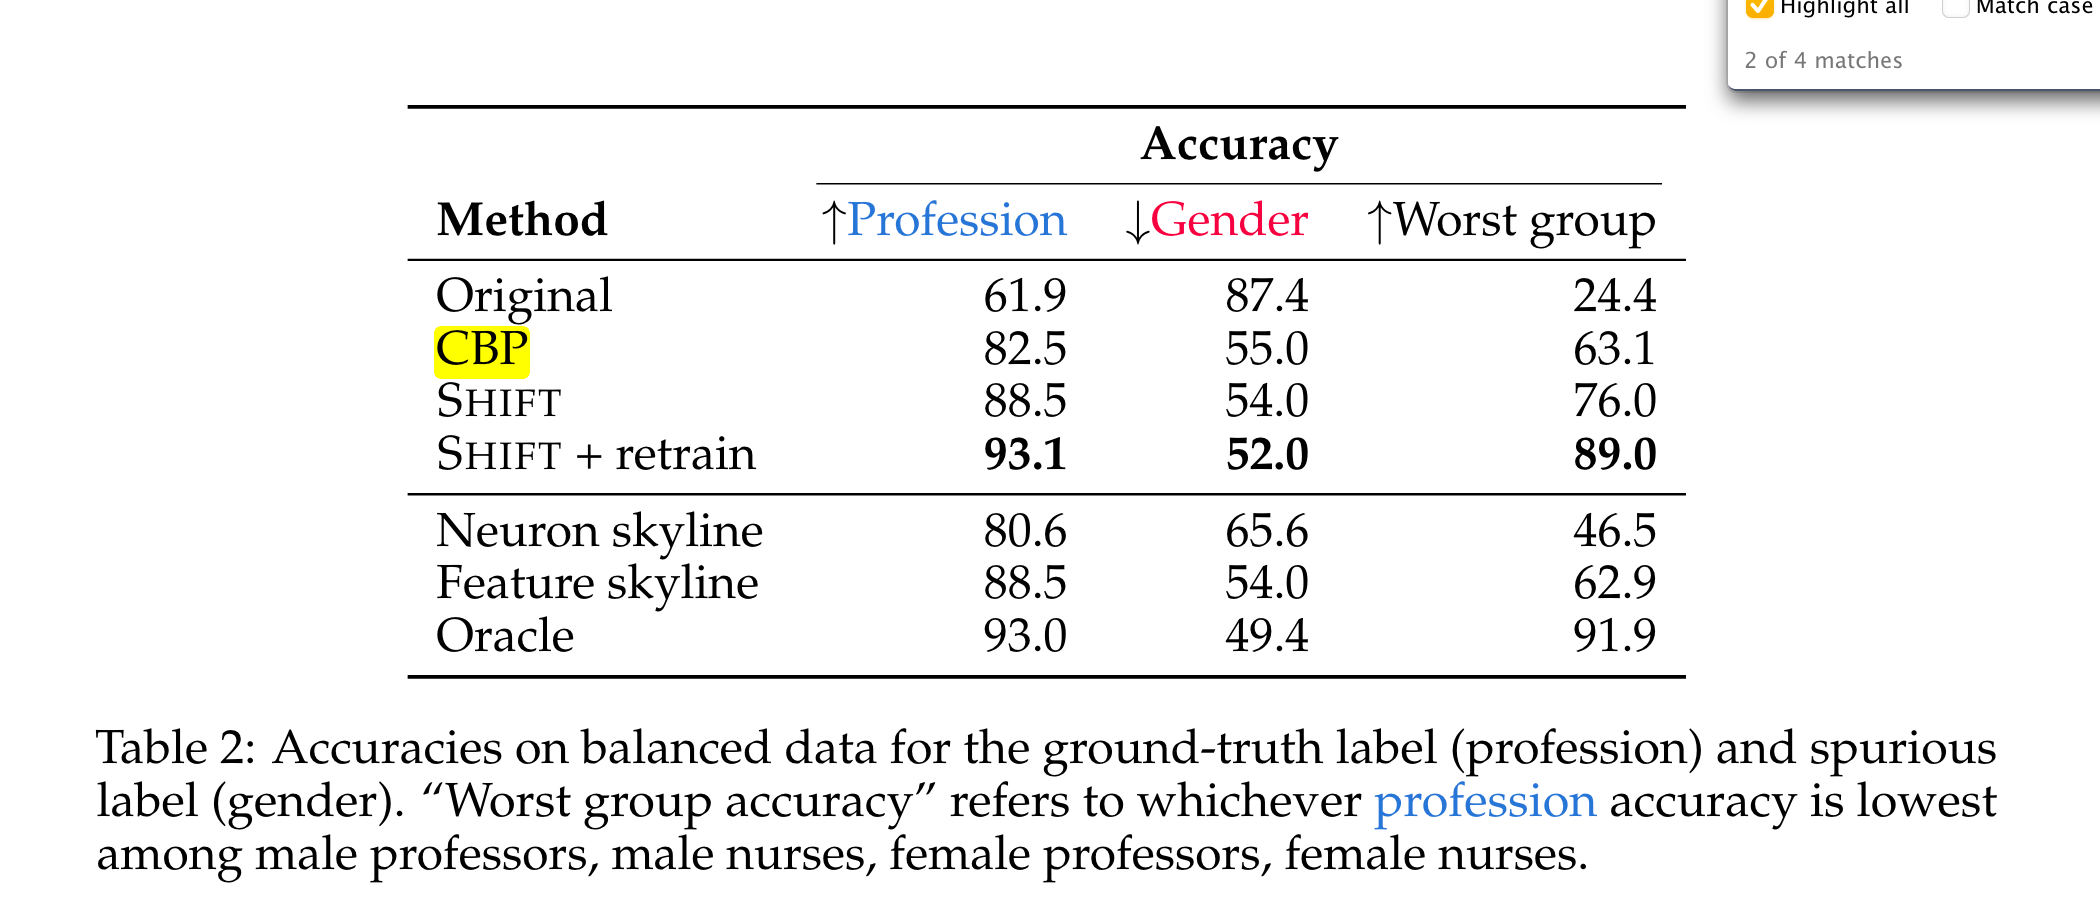

So we can conclude that we only have to find the professional accuracy, where [0] index contains the ground truth label of the profession

In [11]:
# Here we will find the accuracy of the subgroups for both the vanilla model and the model with the mask.

wandb.init(project="sae_concept_eraser")

new_model = my_model()

# Load the state dictionary
# state_dict = t.load("new_model.pth")
# new_model.load_state_dict(state_dict)
new_model = new_model.to(DEVICE)
new_model.eval()

subgroups = get_subgroups(train=False, ambiguous=False)

with t.no_grad():
    for label_profile, batches in subgroups.items():
        corrects = []
        total = 0
        for i in tqdm(range(len(batches))):
            text = batches[i][0]
            labels = label_profile[0] # true label, if [2] then spurious label. We will be training the model in hope that mask will learn which concepts to mask.
            logits = new_model(text)
            preds = (logits > 0.0).long()
            corrects.append((preds == labels).float())
        
        accuracy = t.cat(corrects).mean().item()
        
        if label_profile == (0, 0):
            wandb.run.name = "Vanilla-acc-Male_Prof."
            wandb.log({"Groups Accuracy": accuracy})
        elif label_profile == (0, 1):
            wandb.run.name = "Vanilla-acc-Female_Prof."
            wandb.log({"Groups Accuracy": accuracy})
        elif label_profile == (1, 0):
            wandb.run.name = "vanilla-acc-Male_Nurse"
            wandb.log({"Groups Accuracy": accuracy})
        elif label_profile == (1, 1):
            wandb.run.name = "Vanilla-acc-Female_Nurse"
            wandb.log({"Groups Accuracy": accuracy})

    # print(f'Accuracy for {label_profile}:', test_probe(oracle, get_acts, batches=batches, label_idx=0))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 22%|██▏       | 2970/13315 [03:19<11:35, 14.87it/s]  


KeyboardInterrupt: 

In [ ]:
new_model = t.save(new_model, "model.pth")

In [ ]:
'''
To compare the weights of the model with the original model.
- We will compare the weights of the model with the weights of 
submodules and all. 
- One of the other things that we could do is compare the weights of dictionary with 
the initial dictionary weights. 
- Finally, if these 2 things gets fulfilled, we can compare the weights of the model
with the weights of the original model.


Based on Dr. Geiger text, I will just assume that the weights of the model will remain same and 
will start building the whole model for gender prediction. 

#TODO: Run and train the model on the gender dataset. 
'''

def compare_weights(model, submodules):
    initial_state = model.gpt_neox.embed_in.state_dict()
    for module in submodules:
        trained_state = module.state_dict()
        # print(f"Initial weights for {module}: {initial_state}")
        # print(f"Trained weights for {module}: {trained_state}")
        if initial_state != trained_state:
            print(f"Weight for module has been updated!")
            print(initial_state)
            print()
            print(trained_state)
        else:
            print(f"Weight for module remains unchanged")
        break

compare_weights(new_model, submodules)

In [ ]:
print(new_model.embed_mask)
print(new_model.l1_mask)
print(new_model.l2_mask)
print(new_model.l3_mask)
print(new_model.l4_mask)

In [ ]:
print(model.gpt_neox.embed_in.weight)
print()
print(submodules[0].weight)

In [ ]:

DEVICE = 'cpu'
lm = LanguageModel('EleutherAI/pythia-70m-deduped', device_map=DEVICE, dispatch=True)
lm.gpt_neox.embed_in.weight  